# Solar Cycle Progression

Analysing solar cycle data from the NOAA Space Weather Prediction Center.

The aim of this analysis is to use measurements of the mean monthly sunspot number (SSN) which has been accuretly recorded since 1755 to view historic trends, plot a smoothed SSN time series, and finally predict the progression of the next solar maxima.

https://www.swpc.noaa.gov/products/solar-cycle-progression

In [185]:
import urllib, json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [186]:
jsonURL = "https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json"
with urllib.request.urlopen(jsonURL) as url:
    dataJSON = json.load(url)
data = pd.DataFrame.from_dict(dataJSON)
data.head()

,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.0,-1.0,-1.0,-1.0
1,1749-02,104.3,-1.0,-1.0,-1.0,-1.0,-1.0
2,1749-03,116.7,-1.0,-1.0,-1.0,-1.0,-1.0
3,1749-04,92.8,-1.0,-1.0,-1.0,-1.0,-1.0
4,1749-05,141.7,-1.0,-1.0,-1.0,-1.0,-1.0


In [202]:
# Query data from yr 2000 onwards.
milDt = data[(data['time-tag']>="2012-01") & (data['time-tag']<='2023-11')]
milDt.head()

,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
3156,2012-01,94.4,95.5,90.06,91.4,134.79,124.9
3157,2012-02,47.8,98.1,48.48,93.6,106.86,127.2
3158,2012-03,86.6,98.3,77.55,93.5,115.71,127.3
3159,2012-04,85.9,95.1,84.10,90.7,113.26,126.3
3160,2012-05,96.5,90.9,98.74,87.2,121.40,124.3


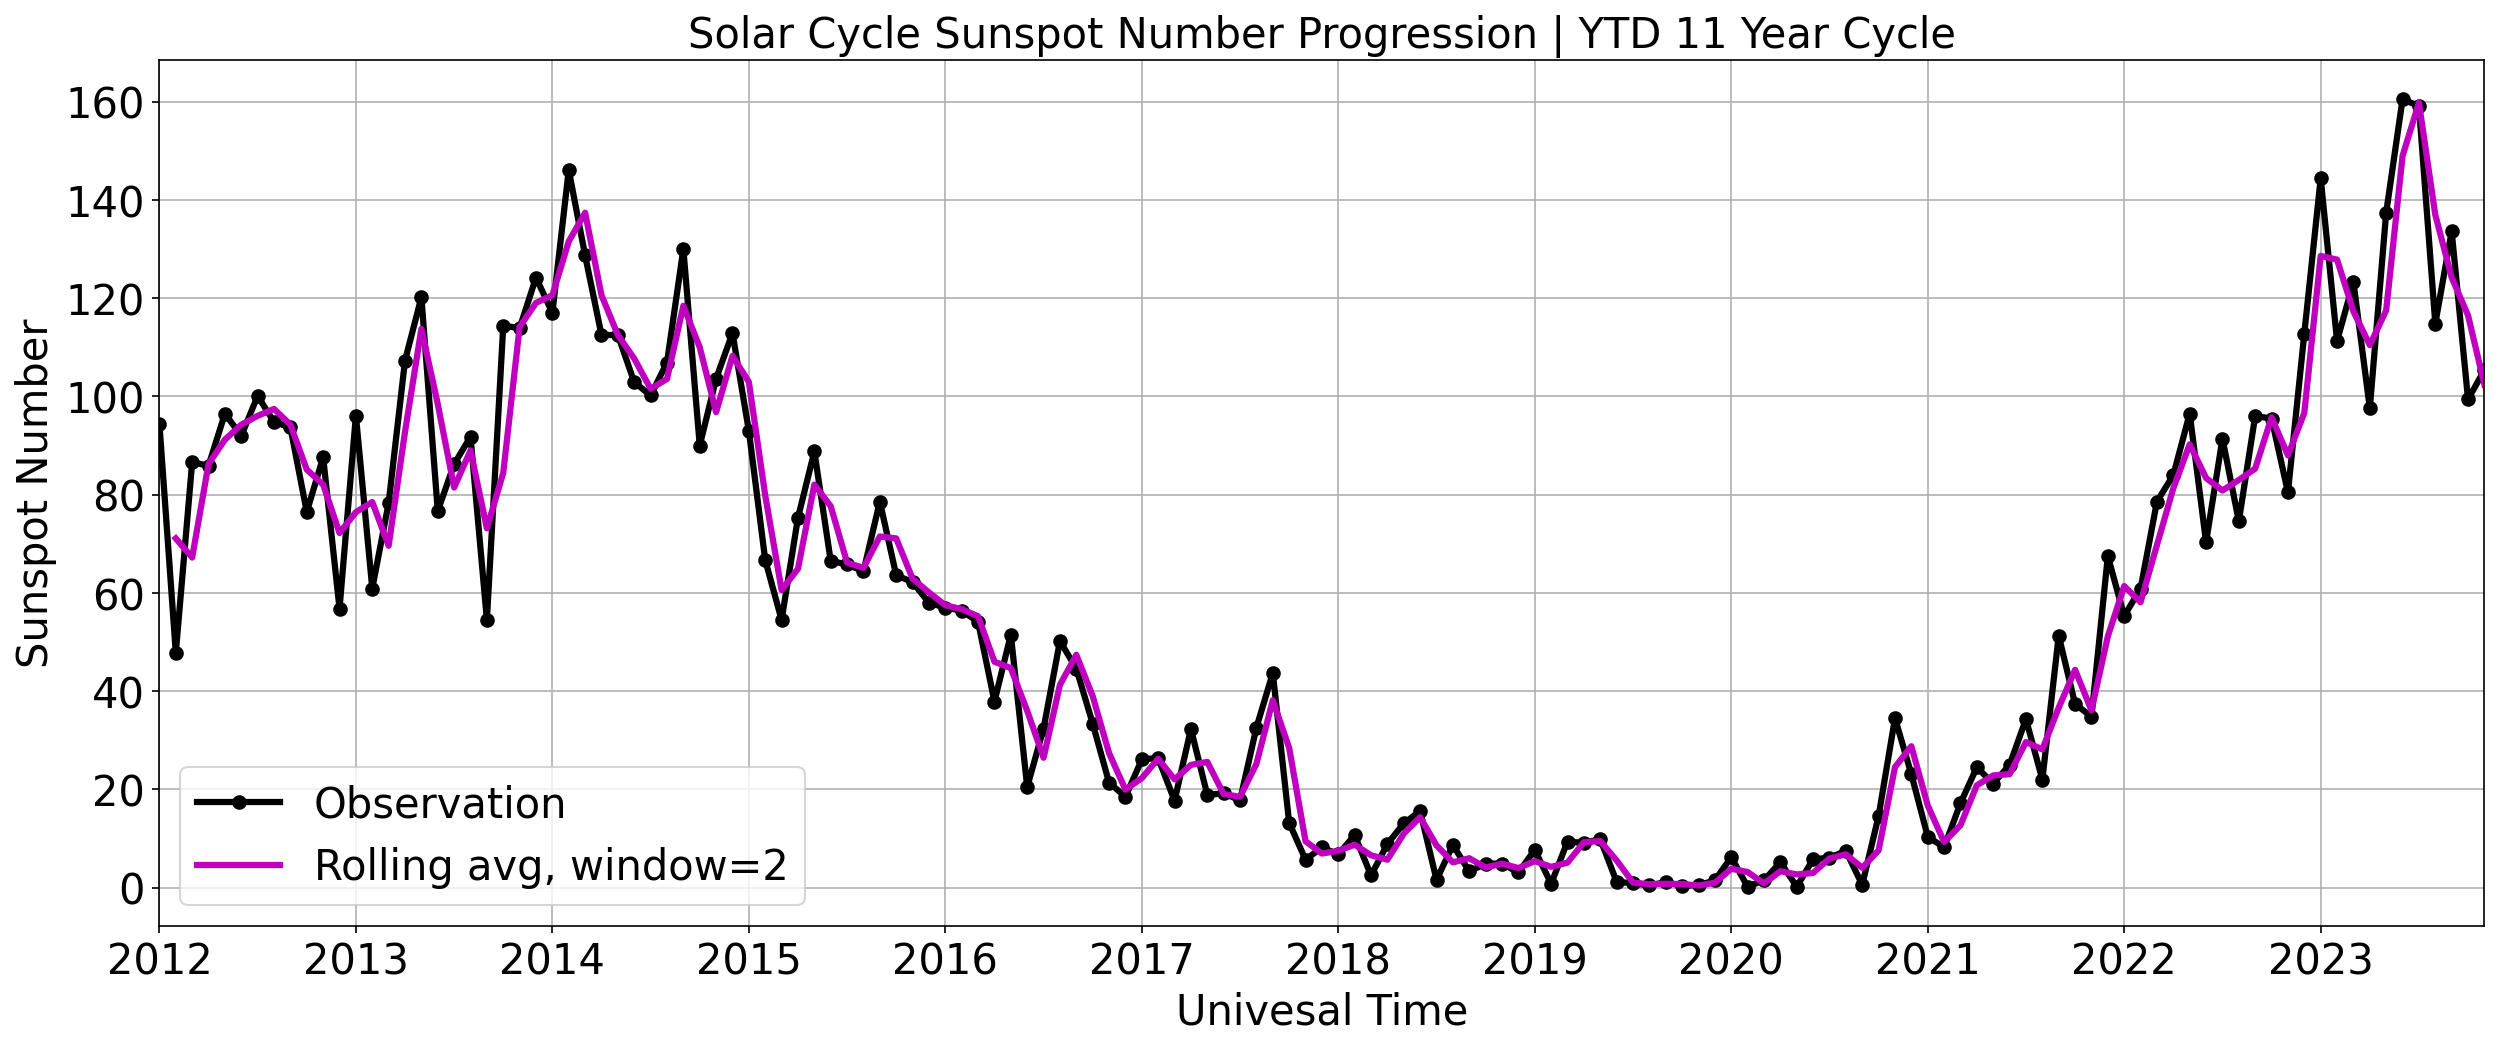

In [206]:
x_width, y_width = 20, 7.5
window = 2
linewidth = 3
fsize = 20

fig, ax = plt.subplots(1,1, figsize=(x_width, y_width), dpi=150)

ax.plot(milDt['time-tag'], milDt['ssn'], '-o', color='k', linewidth=linewidth, label='Observation')
ax.plot(milDt['time-tag'], milDt['ssn'].rolling(window).mean(), color='m', linewidth=linewidth, label=f'Rolling avg, window={window}')

plt.legend(loc='best', fontsize=fsize)

# Set x-ticks to show every year once
plt.xticks(milDt['time-tag'][::12])
xlabels = [str(i)[:4] for i in milDt['time-tag'][::12]]
ax.set_xticklabels(xlabels, fontsize=fsize, rotation=0)

plt.xlim(milDt['time-tag'].min(), milDt['time-tag'].max())

plt.title("Solar Cycle Sunspot Number Progression | YTD 11 Year Cycle", fontsize=fsize)
plt.ylabel("Sunspot Number", fontsize=fsize)
plt.xlabel("Univesal Time", fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.grid()